# NB. Burgers equation (with/without 2/3-dealiasing)
## Philipp Schlatter and Saleh Rezaeiravesh

In this notebook, we time-integrate the Burgers equation using a Fourier-Galerkin method.  In space we use a Fourier method, and in time a simple explicit Euler forward method.

This notebook includes also different types of dealiasing.

In [ ]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 15,
          'legend.loc':'best',
          'figure.figsize': (14,5),
          'lines.markerfacecolor':'none',
         'axes.labelsize': 17,
         'axes.titlesize': 17,
         'xtick.labelsize':15,
         'ytick.labelsize':15,
         'grid.alpha':0.6}
pylab.rcParams.update(params)
#%matplotlib notebook
%matplotlib inline

## Setup and initial condition

We assume a periodic domain of length of $L=2\pi$ so the fundamental wavenumber is $\alpha=2\pi / L = 1$ and thus not included. We want to time-integrate the Burgers equation 

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} =0 \ ,$$

starting from an initial condition $u_0$ up to time $T$.

In physical space we have $N$ grid points for a periodic domain

In [ ]:
N=128
x=np.linspace(0,2*pi,N,endpoint=False)

A simple sine wave is used as initial condition $u_0=\sin(x)$ at time $t=0$

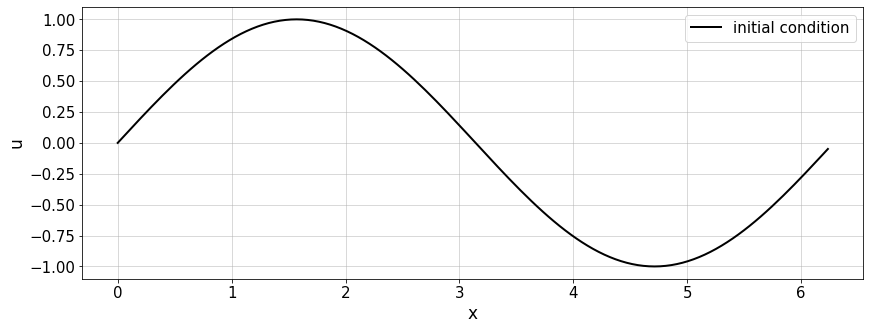

In [ ]:
u0 = np.sin(x)+0*np.sin(x-0.1)**2
plt.figure(figsize=(14,5))
plt.xlabel('x');plt.ylabel('u')
plt.plot(x,u0,'-k',lw=2,label='initial condition')
plt.legend(loc='best')
plt.grid()

We transfrom this initial condition into Fourier space, using the Fourier matrix introduced earlier (could be done using an FFT as well of course, then scale with $N$). We copy the data around to match the data format.

In [ ]:
def FourMat(n):
    """ Fourier Matrix """    
    W=np.exp(-1j*2*pi/n)
    I,J=np.meshgrid(np.arange(n),np.arange(n))
    return (W**(I*J))
F=FourMat(N)/N
Finv=np.linalg.inv(F)

# you can use the DFT
# u0hh=F@u0
# or the FFT
u0hh=np.fft.fft(u0)/N

# of course, since we only have a cosine as initial condition, 
# we could specify that also directly in Fourier space in u0hh[1] and u0hh[N-1]

Here we have to be a bit careful. We need to keep in mind that the *oddball mode* in Fourier space needs to be set to zero. This means that $N$ points in physical space correspond to wavenumbers from $k=-K\ldots K$ with $K=N/2-1$, and the mode $k=-N/2$ has to be set to zero.

In [ ]:
K=int(N/2)-1
u0hh[K+1]=0
u0h=np.fft.fftshift(u0hh) 

## Fourier-Galerkin spectral method

Now we can do a time integration of

$$
\frac{\mathrm{d}\hat{u}_l}{\mathrm{d}t} + \sum_{\substack{k=-K\\ l=k+m\\ |m|\leq K}}^K \mathrm{i} m \hat{u}_k\hat{u}_m = 0 \ ,
$$

where $l$ goes from $-K$ to $K$, using an explicit Euler method. We choose a time step $\Delta t=0.01$ and a final time $T$ (set in the code, choose $T=0.9$ for something smooth, or $T=1.1$ for wiggles)



t=1.100: E/E0=  1.00435229126769


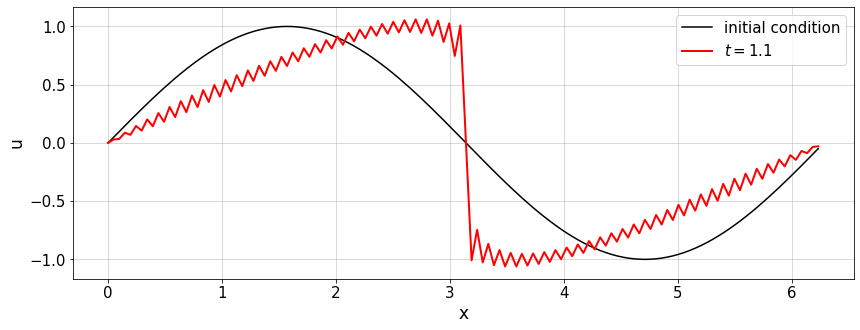

In [ ]:
Tmax = 1.1;

dt=0.01
nt=int(Tmax/dt)
t=np.arange(nt)+1;

kk=range(-K,K+1)

uh=u0h
E0 = np.linalg.norm(uh)**2
time=0

for t_ in t:
    
    f=0*uh
    for l_ in kk:
        
        for k_ in kk:
            m_=l_-k_
            if abs(m_)<=K:
                f[l_+int(N/2)] += 1j*m_*uh[k_+int(N/2)]*uh[m_+int(N/2)]
        
    time=t_*dt
    uh = uh-dt*f
    
print('t=%5.3f: E/E0=%18.14f' % (time,np.linalg.norm(uh)**2/E0))  # not fully correct in spectral space
    
uhh=np.fft.ifftshift(uh)

# you can use the DFT
#u1=Finv@uhh  
# or the FFT
u1=np.fft.ifft(uhh*N)

    
plt.figure(figsize=(14,5))
plt.xlabel('x');plt.ylabel('u')
plt.plot(x,u0,'-k',label='initial condition')
plt.plot(x,u1.real,'-r',lw=2,label='$t=$'+str(time))
plt.legend(loc='best')
plt.grid()  

We integrate now up to $T$, which means that the peak should have travelled by a length of $T$ (speed 1). One can see that there are some wiggles appearing for $t>0.9$ or so, which is due to the nonlinearity and the missing dissipation.

## Homework task - Dealiasing

Your task is now to extend this example with a pseudo-spectral evaluation of the nonlinear term 

$$\sum_{\substack{k=-K\\ l=k+m\\ |m|\leq K}}^K \mathrm{i} m \hat{u}_k\hat{u}_m$$

1. Replace this convolution sum with an evaluation using FFTs. Remember to use ``fftshift`` to re-organise the array before and after the transforms. Run the code for shorter time $T=0.1$ and longer time $T=1$. What do you observe?
2. Try to address the problem of aliasing errors by using the $2/3$-rule, *i.e.* by filtering in Fourier space before/after the transforms. Do the results change for shorter and longer times, respectively?
3. [voluntary] Try to implement the $3/2$ rule, $i.e.$ extend the arrays before the transform and reduce after the back-transform. Do you see any differences to the $2/3$-rule?

Prepare and hand in a short report discussing your results together with the codes.

The below code is our solution to the problem (using the 2/3 rule). Note that the following variables are used:
``Nps`` is the number of Fourier modes in the FFT (thus in physical space and corresponding to ``N`` in the Galerkin case). ``deal`` is the number of modes to be zeroed on each side. That means that full dealiasing using the 2/3-rule corresponds to 
``Nps=3/2*N`` and ``deal=N/4=Nps/6``. No dealiasing corresponds to ``Nps=N`` and ``deal=0``. In all cases, the oddball mode is filtered (as it is for the Galerkin case).

To simplify the comparison with the Galerkin method, we introduce the variables ``Nmodes`` which is the number of actual modes that are used to compute the solution on (to be compared to ``N`` in the Galerkin case in spectral space), and ``Ndeal`` the number of modes to be zeroed. Thus, full dealiasing is ``Ndeal=Nmodes/2``.

Note that filtering of the oddball mode is done in all cases.

In [ ]:
# To calcuate the number of active Fourier modes (positive and negative):
# N=128 --> 127 modes (without oddball)
# Nps=192, deal=32 --> 192-2*32-1 = 127 modes (without oddball)
#
# Full dealiasing: Nps = 3/2*N and deal = N/4 = Nps/6

# deal = 30 --> wiggles at 60
# deal = 24 --> wiggles at 48
# deal = 16 --> wiggles at 32 (96-16-32=48)
# deal = 12 --> wiggles at 24 and 48 (96-12-24=60)
# deal = 8 --> wiggles at 16 and 64 (96-8-16=72)
# deal = 4 --> wiggles at 8

# Nmodes is the resolution in spectral space, Ndeal how many additional modes
# Therefore, full dealiasing would correspond to Ndeal=Nmodes/2.
Nmodes = 128;
Ndeal = 64;

Nps=Nmodes+Ndeal;
deal = int(Ndeal/2);

xps=np.linspace(0,2*pi,Nps,endpoint=False)
u0ps = np.sin(xps)+0*np.sin(xps-0.1)**2
u0hps=np.fft.fft(u0ps)/Nps
Kps=int(Nps/2)-1
u0hps[Kps+1]=0

In the following code, the form of the nonlinear term and the time step can be chosen. The nonlinear term can be written as:
$$u\frac{\partial u}{\partial x} = \frac{1}{2}\frac{\partial u^2}{\partial x}= \frac{1}{2}\left[u\frac{\partial u}{\partial x} + \frac{1}{2}\frac{\partial u^2}{\partial x}\right]$$
in the convective, conservative and skew-symmetric form, respectively.

t=1.100 E/E0=  1.00435229126769


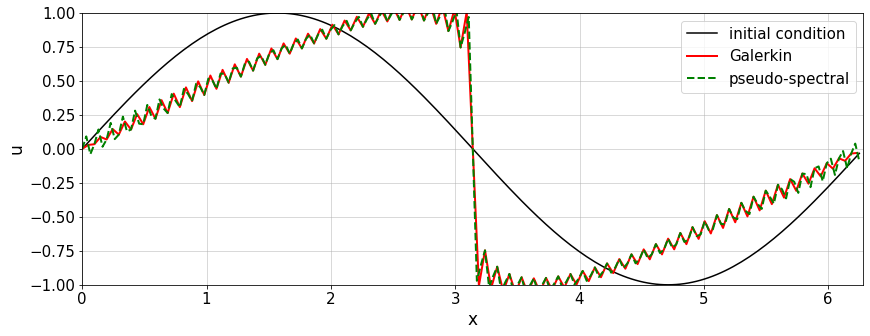

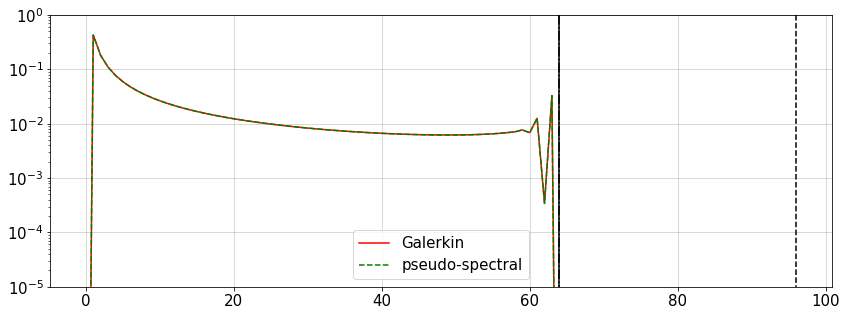

In [ ]:
## Pseudo-spectral (in normal FFT ordering)

# form of the nonlinear term: 
# 1: convective form
# 2: conservative/divergence form
# 3: skew-symmetric form
form = 1;

dt=0.01
nt=int(Tmax/dt)
t=np.arange(nt)+1;

kk=range(-Kps-1,Kps+1)
k = np.fft.ifftshift(kk)

u=u0hps

E0 = np.linalg.norm(u)**2
time=0

for t_ in t:

    if form==1:
        # convective form
        duhat = np.multiply(1j*k,u)
        ur  = np.fft.ifft(u)
        dur = np.fft.ifft(duhat)
        wr  = np.multiply(ur,dur)
        w   = np.fft.fft(wr*Nps)
    elif form==2:
        # conservative form
        ur  = np.fft.ifft(u)
        wr  = 0.5*np.multiply(ur,ur)
        w   = np.fft.fft(wr*Nps)
        w   = np.multiply(1j*k,w)
    elif form==3:
        # skew-symmetric form
        duhat = np.multiply(1j*k,u)
        ur  = np.fft.ifft(u)
        dur = np.fft.ifft(duhat)
        wr  = np.multiply(ur,dur)
        w1  = np.fft.fft(wr*Nps)
    
        wr  = 0.5*np.multiply(ur,ur)
        w2  = np.fft.fft(wr*Nps)
        w2  = np.multiply(1j*k,w2)
    
        w=(w1+w2)/2
    
    time=t_*dt
    u = u-dt*w
    
    u[Kps+1+np.arange(-deal,deal+1)] = 0 # oddball + dealiasing
    
print('t=%5.3f E/E0=%18.14f' % (time,np.linalg.norm(u)**2/E0))  

u3=np.fft.ifft(u*Nps)
    
plt.figure(figsize=(14,5))
plt.xlabel('x');plt.ylabel('u')
plt.plot(xps,u0ps,'-k',label='initial condition')
plt.plot(x,u1.real,'-r',lw=2,label='Galerkin')
plt.plot(xps,u3.real,'--g',lw=2,label='pseudo-spectral')
plt.legend(loc='best')
plt.grid()
plt.xlim((0,2*pi));
plt.ylim((-1,1));

plt.figure(figsize=(14,5))
plt.semilogy(np.arange(0,N/2+1),abs(uhh[0:int(N/2+1)])+1e-15,'-r',label='Galerkin')
plt.semilogy(np.arange(0,Nps/2+1),abs(u[0:int(Nps/2+1)])+1e-15,'--g',label='pseudo-spectral')
plt.plot((N/2,N/2),(1,1e-15),'k')
plt.plot((Nps/2,Nps/2),(1,1e-15),'k--')
plt.plot((2/3*Nps/2,2/3*Nps/2),(1,1e-15),'k-.')
plt.legend(loc='best')
plt.grid()
plt.ylim((1e-5,1));


## Things to do to analyse and understand the results

1. Start with the Galerkin case in the beginning. The formulation should be energy conservative up to the accuracy of the time stepper (which is first order). Verify this by making the time step smaller (e.g. from $\Delta t=10^{-2}$ to $10^{-3}$).
2. Then consider the pseudo-spectral evaluation. Take $N=128$ points and full dealiasing with 64 more nodes. Run it again, and confirm again conservation of energy. You can observe:
  - indeed it is conservative
  - your solution looks very similar in physical space and exactly the same in spectral space. This confirms that full dealiasing is in fact the same as the Galerkin method
  - There are differences in physical space. Why? Well, this is because you actually interpolate the spectral solution onto a different number of nodes in physical space (because we use the 2/3 rules). Test this by increasing the 64 dealiasing modes to say 256 and zoom in the regions of differences. You can then see that the lines coincide.
  - the choice of the form of the nonlinear term does not matter.
  - Probably most importantly: The solution is much faster!
  
3. Now take away the dealiasing. Start with the convective form. What happens? You see that the spectrum suddenly indicates lower energy at higher wavenumbers, and thus less wiggles in physical space.
4. Take the divergence form: Now suddenly you have much more wiggles.
5. Take the skew-symmetric form: Now the eigenvalues are forced to be exactly on the imaginary axis, which means you have no growth of energy, and the spectrum looks much like the Galerkin one. However, the cost is larger as you do more FFTs.
6. Is the system still energy conservative for the three different forms? No, why? 